In [1]:
import yfinance as yf

# Scarica i dati storici di un ETF
etf = yf.Ticker("^GSPC")
data = etf.history(period="10y")  # Dati dell'ultimo anno
data.to_csv("sp500.csv")  # Salva in un file CSV

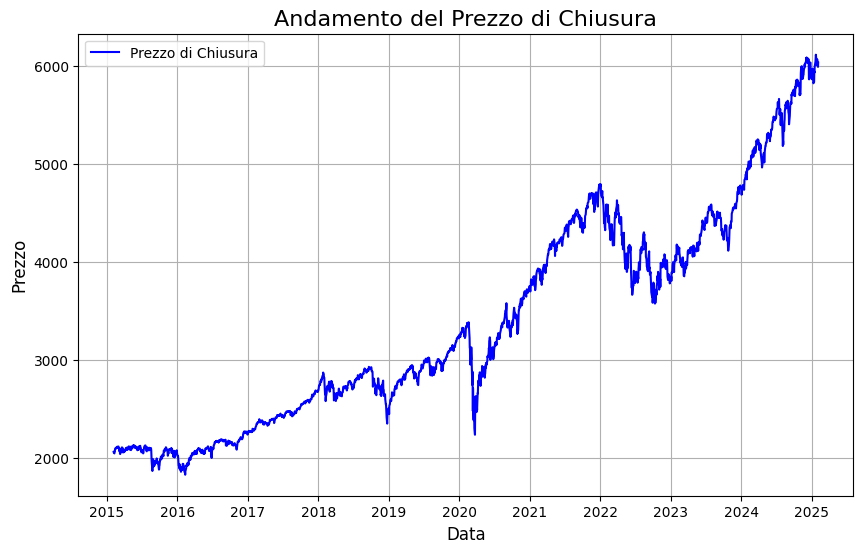

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Leggi il file CSV
df = pd.read_csv('sp500.csv', parse_dates=['Date'])

# Imposta la colonna 'Date' come indice
df.set_index('Date', inplace=True)

# Plot dell'andamento del prezzo di chiusura
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Prezzo di Chiusura', color='blue')

# Personalizzazione del grafico
plt.title('Andamento del Prezzo di Chiusura', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Prezzo', fontsize=12)
plt.legend()
plt.grid()
plt.show()

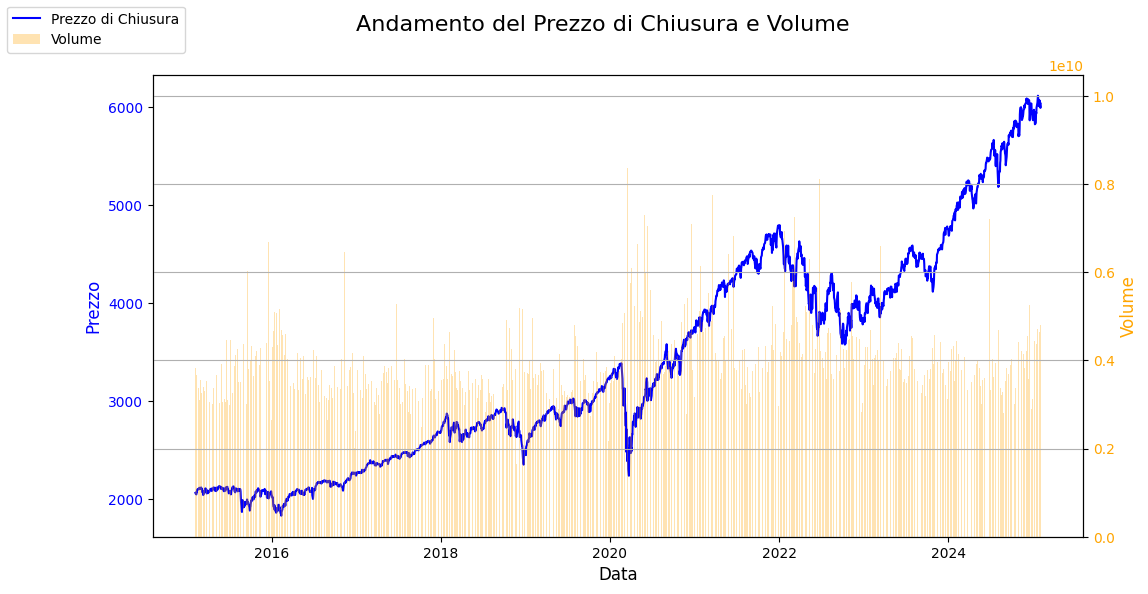

In [3]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Grafico del prezzo di chiusura
ax1.plot(df.index, df['Close'], label='Prezzo di Chiusura', color='blue')
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Prezzo', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Grafico del volume sugli assi secondari
ax2 = ax1.twinx()
ax2.bar(df.index, df['Volume'], color='orange', alpha=0.3, label='Volume')
ax2.set_ylabel('Volume', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titolo e legenda
fig.suptitle('Andamento del Prezzo di Chiusura e Volume', fontsize=16)
fig.legend(loc='upper left')
plt.grid()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Caricamento del dataset
data = pd.read_csv("sp500.csv")
data = data.sort_values(by="Date")

# Calcola la variazione percentuale giornaliera
data["Pct_Change"] = data["Close"].pct_change() * 100  # Converte in %

# Rimuove il primo valore NaN (derivante dalla differenza con il giorno precedente)
data = data.dropna()

# Applica lo StandardScaler sulla variazione percentuale
scaler = MinMaxScaler(feature_range=(-1, 1))
pct_scaled = scaler.fit_transform(data["Pct_Change"].values.reshape(-1, 1))

# Divisione in train, validation e test
split_ratio = 0.8
split_index = int(len(pct_scaled) * split_ratio)

train_data = pct_scaled[:split_index]

split_index2 = int(len(train_data) * split_ratio)
valid_data = train_data[split_index2:]
train_data = train_data[:split_index2]
test_data = pct_scaled[split_index:]

# Verifica delle dimensioni
print(f"len(data): {len(pct_scaled)}")
print(f"Train + valid: {split_index}")
print(f"Train size: {len(train_data)}")
print(f"Valid size: {len(valid_data)}")
print(f"Test size: {len(test_data)}")
print(f"Train + valid size: {len(train_data) + len(valid_data)}")


len(data): 2514
Train + valid: 2011
Train size: 1608
Valid size: 403
Test size: 503
Train + valid size: 2011


In [13]:
import numpy as np

# Configurazione della finestra temporale
window = 50

# Funzione per creare sequenze temporali dalle variazioni percentuali
def create_sequences(data, window):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])   # Finestra di variazioni percentuali
        y.append(data[i+window])     # Prossima variazione percentuale
    return np.array(x), np.array(y)

# Crea le sequenze temporali sulla variazione percentuale (già scalata)
x_train, y_train = create_sequences(train_data, window)
x_valid, y_valid = create_sequences(valid_data, window)
x_test, y_test = create_sequences(test_data, window)

print(x_test[-1])  # Controllo dell'ultima sequenza di test

# Aggiungi una dimensione extra per la rete neurale (necessario per LSTM)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Verifica delle dimensioni
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


[[ 0.30980496]
 [-0.04179298]
 [ 0.43262382]
 [ 0.26559461]
 [ 0.22567903]
 [ 0.46665796]
 [-0.38282549]
 [ 0.4564694 ]
 [ 0.1746539 ]
 [-0.00348128]
 [ 0.49604189]
 [-0.210537  ]
 [ 0.17884611]
 [-0.59182144]
 [-0.30813256]
 [ 0.68464577]
 [-0.52668759]
 [-0.04611187]
 [ 0.29515542]
 [-0.38842348]
 [-2.67454426]
 [-0.12091996]
 [ 0.92578637]
 [ 0.60628152]
 [ 0.94127484]
 [-0.07993622]
 [-1.02993443]
 [-0.99838041]
 [-0.42595977]
 [-0.24212407]
 [ 1.07982795]
 [ 0.45024848]
 [-1.03423185]
 [ 0.09543476]
 [-1.41848603]
 [ 0.09678026]
 [ 0.05849835]
 [ 1.58976951]
 [-0.23220517]
 [ 0.84746206]
 [ 0.73838415]
 [ 0.50375988]
 [ 0.4302176 ]
 [-0.29843186]
 [-1.34436636]
 [ 0.77849273]
 [-0.4611135 ]
 [ 0.42682155]
 [-0.49393324]
 [-0.72244602]]
x_train shape: (1558, 50, 1), y_train shape: (1558, 1)
x_valid shape: (353, 50, 1), y_valid shape: (353, 1)
x_test shape: (453, 50, 1), y_test shape: (453, 1)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

#model = Sequential()

# Layer convolutivi iniziali
#model.add(Conv1D(8, 3, input_shape=(100, 1), activation="relu"))  # Kernel più piccolo per adattarsi alla finestra ridotta
#model.add(MaxPooling1D(2))  # Riduce la dimensione a metà
#model.add(Conv1D(16, 3, activation="relu"))  # Aumentiamo le feature map
#model.add(MaxPooling1D(2))  # Riduce ancora

# Batch Normalization per stabilità
#model.add(BatchNormalization())

# Flatten per passare ai layer completamente connessi
#model.add(Flatten())

# Layer completamente connessi
#model.add(Dense(32, activation='relu'))  # Ridotto il numero di neuroni
#model.add(Dropout(0.4))  # Dropout per regolarizzazione
#model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(8, activation='relu'))

# Layer finale per output
#model.add(Dense(1))  # Singolo output per previsione

# Compilazione del modello
#model.compile(optimizer="rmsprop", loss='mse', metrics=['mean_absolute_error'])

#model.summary()
# train the network

#hist = model.fit( x=x_train, # training examples
#                  y=y_train, # desired output
#                  epochs=200,      # number of training epochs
#                  validation_data=(x_valid,y_valid), 
#                  verbose=1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Creazione del modello LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output: variazione percentuale predetta

# Compilazione
model.compile(optimizer='adam', loss='mse')

# Training
#model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


# Training
hist = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_valid, y_valid))


Epoch 1/50


c:\Users\sfori\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 1.0813 - val_loss: 1.5108
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 1.1785 - val_loss: 1.5136
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 1.0047 - val_loss: 1.5134
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 1.1825 - val_loss: 1.5162
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 1.2217 - val_loss: 1.5147
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 1.0723 - val_loss: 1.5129
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.9262 - val_loss: 1.5073
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 1.0835 - val_loss: 1.5111
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.9963 - val_loss: 1.5076
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 1.0871 - val_loss: 1.5066
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.8076 - val_loss: 1.5093
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 1.2600 -

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5943
0.6866422891616821


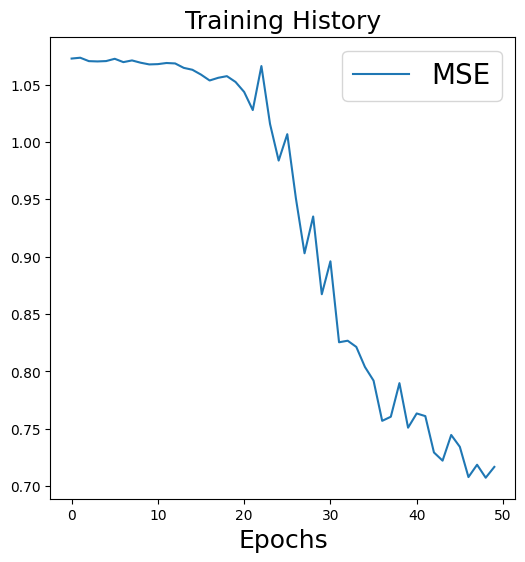

In [9]:
import matplotlib.pyplot as plt
# plot training epochs

fig, axes = plt.subplots(figsize=(6,6))

axes.plot(hist.history['loss'], label='MSE')

axes.set_title("Training History", fontsize=18)
axes.set_xlabel("Epochs", fontsize=18)
axes.legend(fontsize=20)

# Final accuracy
print ( model.evaluate(x_train, y_train))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2514
2020


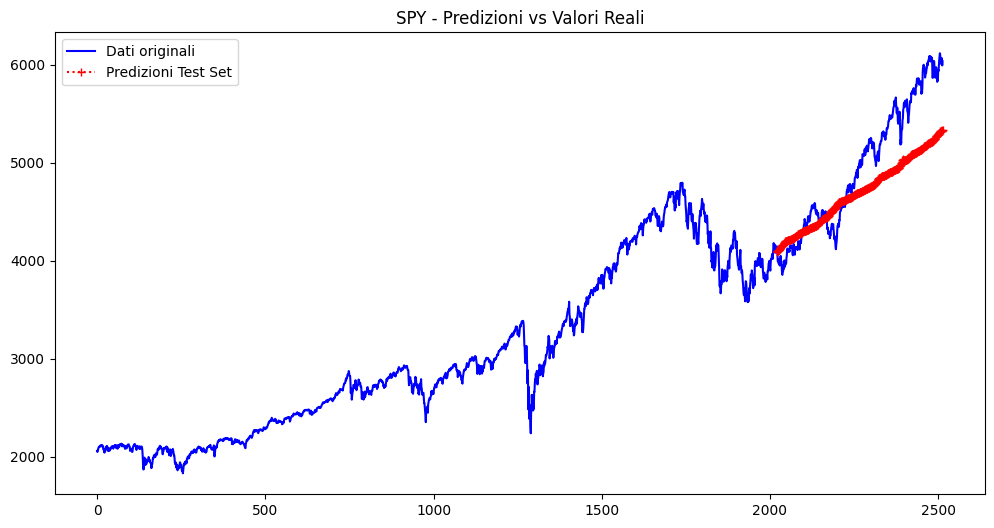

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Predizione
y_pred_scaled = model.predict(x_test)

y_pred = scaler.inverse_transform(y_pred_scaled)
# Ripristina le variazioni percentuali originali
#y_pred_variation = scaler.inverse_transform(y_pred_scaled)  # Ottieni variazione %
#y_test_variation = scaler.inverse_transform(y_test.reshape(-1, 1))  # Anche il test

# Ricostruzione del prezzo predetto
predicted_prices = []
real_prices = []

print(len(data['Close']))
print(len(train_data) + len(valid_data) + window - 1)

last_known_price = data['Close'].iloc[-len(y_test)]

predicted_prices = [last_known_price]
for pct_change in y_pred:
    new_price = predicted_prices[-1] * (1 + pct_change / 100)
    predicted_prices.append(new_price)

predicted_prices = predicted_prices[1:]

# Creazione del plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta tutti i valori originali del dataset
ax.plot(range(len(data)), data['Close'], label="Dati originali", color='blue')

# Plotta le predizioni sul test set (dopo il punto di separazione)
ax.plot(range(len(train_data) + len(valid_data) + window, len(data)), 
        predicted_prices, 'r+:', label="Predizioni Test Set")

ax.set_title('SPY - Predizioni vs Valori Reali')
ax.legend()
plt.show()


Fare predizione su giorni futuri:
Dare in pasto a rete neurale valori di {window} giorni prima e l'output è il valore del window +1 giorno

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.48702574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.48581266]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0.4845482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.4833181]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.48211992]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.48088533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[0.47967184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[0.47847176]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.47730982]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.47616303]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.4749965]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.47383446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.47268248]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.47153848]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.4704017]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.46927148]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.4681474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.4670292]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.46591693]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

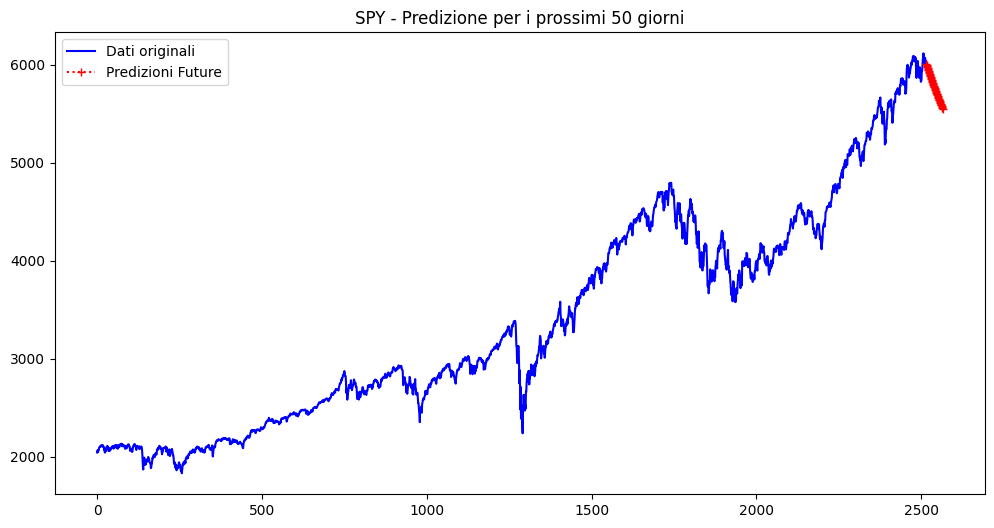

In [17]:
#Predizione da oggi ai prossimi giorni

import numpy as np

future_days = 50  # Numero di giorni futuri da prevedere
last_window = np.copy(x_test[-1:])  # Prende l'ultima finestra mantenendo la prima dimensione

future_predictions = []  # Per salvare le predizioni future
for i in range(future_days):
    next_pred = model.predict(last_window)  # Predizione per il giorno successivo
    print(next_pred[-1])
    future_predictions.append(next_pred[-1])  # Salva la predizione    
    # Aggiorna il dataset di input per la prossima iterazione
    # Shift a sinistra tutti gli elementi
    last_window = np.roll(last_window, shift=-1, axis=1)

    # Inserisce la nuova predizione nell'ultima posizione
    last_window[0, -1, 0] = next_pred.item()

# Converti le predizioni alla scala originale
future_predictions_original = scaler.inverse_transform(future_predictions)

# Creazione del plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta tutti i dati originali
ax.plot(range(len(data)), data['Close'], label="Dati originali", color='blue')

# Plotta le predizioni future
ax.plot(range(len(data), len(data) + future_days), future_predictions_original, 'r+:', label="Predizioni Future")



ax.set_title(f"SPY - Predizione per i prossimi {future_days} giorni")
ax.legend()
plt.show()
